In [1]:
# Jupyter Notebook Chapter 13 Exercise Program
# DSC 530
# Week 11
# EDA Assignment Week 11
# David Berberena
# 2/25/2024

# Program Start

# Importing of needed libraries and data to establish the correct coding environment

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist
    
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query("outcome in [1, 3, 4]").prglngth
cdf = thinkstats2.Cdf(complete, label="cdf")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

import survival

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for empiricaldist: filename=empiricaldist-0.7.2-py3-none-any.whl size=12220 sha256=cf8d541030b700729dd3483a1887f21b0c45d6ebf39a7700b7091a23364069a0
  Stored in directory: c:\users\dbzda\appdata\local\pip\cache\wheels\e1\3b\7b\9e05941453eeac3d404f25bd2afefa929395b35f6de9770be7
Successfully built empiricaldist
Downloaded survival.py


In [5]:
# Importing of needed libraries and data to establish the correct coding environment

download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

Downloaded 1995FemRespData.dat.gz
Downloaded 2006_2010_FemRespSetup.dct
Downloaded 2006_2010_FemResp.dat.gz


In [11]:
# Importing of needed libraries and data to establish the correct coding environment

from collections import Counter


def EstimateHazardFunction(complete, ongoing, label="", verbose=False):

    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

def AddLabelsByDecade(groups, **options):

    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.Plot([15], [1], label=label, **options)

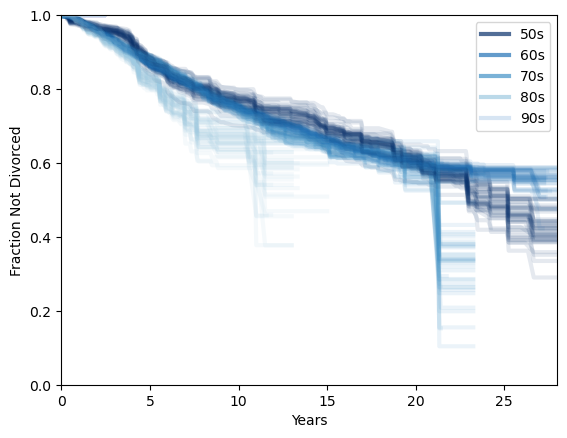

In [19]:
# Exercise 13-1

# In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if 
# applicable, encoded in century-months. Compute the duration of marriages that have ended in divorce, and the duration, so
# far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage. Use resampling to
# take into account sampling weights, and plot data from several resamples to visualize sampling error.

# Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

def CleanData(resp):

    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

# ResampleDivorceCurve() function is defined to resample the complete/ongoing duration pairs and plot the samples 
# The function takes multiple resp variables as an argument

def ResampleDivorceCurve(resps):

    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="blue", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])
    
# ResampleDivorceCurveByDecade() function is defined to resample the complete/ongoing duration pairs, group the samples
# by decade of occurrence, and plot the samples with axis labeling
# This function also takes multiple resp variables as an argument

def ResampleDivorceCurveByDecade(resps):

    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction Not Divorced", axis=[0, 28, 0, 1])
    
# EstimateSurvivalByDecade() function is created to attach the survival estimation to the decade groups and plot them
# The function takes two arguments: the group and a dictionary of key value pairs that correspond with the decade group

def EstimateSurvivalByDecade(groups, **options):

    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)
        
# EstimateSurvival() function is necessary to create the key value pair that shows the survival estimation for the complete
# and ongoing duration of divorce 

def EstimateSurvival(resp):

    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

ResampleDivorceCurveByDecade([married6, married7])
